# Renishaw inVia Raman Mapping Code

Code to process Renishaw inVia Raman maps exported as .txt

In [1]:
# import modules
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib import rcParams
import matplotlib.cm as cm
import math
import numpy as np
import pandas as pd
import os
import chart_studio.plotly as py
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from mpl_toolkits import mplot3d
from pylab import *
from BaselineRemoval import BaselineRemoval

%matplotlib inline

# specify sample path and export path
sample_folder = r'C:\Users\tl457\OneDrive - University Of Cambridge 1\1_Data\220318-Raman-Map'
export_folder = r'C:\Users\tl457\OneDrive - University Of Cambridge 1\1_Data\220318-Raman-Map'

# specify matplotlib configuration file name
rc_fname = r'C:\Users\tl457\Documents\GitHub\spectroscopy\plotting_params.txt'

# define functions
def find_nearest_wav(wav_array, wavelength):
    """Function to find the nearest wavelength to the wavelength specified (float)
	Args:
		  wav_array being an array of wavelengths
            wavelength representing the wavelength you wish to search for
	Returns:
		Float: closest wavelength in wav_array
		"""
    idx = np.searchsorted(wav_array, wavelength, side="left")
    if idx > 0 and (idx == len(wav_array) or math.fabs(wavelength - wav_array[idx-1]) < math.fabs(wavelength - wav_array[idx])):
        return wav_array[idx-1]
    else:
        return wav_array[idx]
        
def normalize_2d(matrix):
    """Function to normalise a matrix using the Frobenius norm
	Args:
		  matrix being a 2D array 
	Returns:
		Array: normalised matrix
		"""
    norm = np.linalg.norm(matrix)
    matrix = matrix/norm  # normalized matrix
    return matrix

In [2]:
# specify file name and parameters for processing
fn='Map_220225_WG_Acrylate_1p3mW_1P_1800G.txt'
wav_lower_limit=1100 # code will ignore wavenumbers below this limit for processing
sav_gol_order=3 # SG filtering applied to reduce noise
sav_gol_window=25 # SG filtering applied to reduce noise

# create DataFrames
data=pd.read_csv(os.path.join(sample_folder,fn),sep='\t',skiprows=1,names=['X','Y','Wavenumber','Intensity'])
x_points=data['X'].unique()
y_points=data['Y'].unique()
wav_points=np.sort(data['Wavenumber'].unique())

# Specify y-point and wavenumbers to exclude from analysis
y_points=y_points[y_points == 25041.7]
x_points=x_points[x_points > -2410]
wav_points=wav_points[wav_points > wav_lower_limit]

# apply baseline removal routine followed by SG filtering to remove noise
index_fitted=[]
data_fitted=[]
data_fitted_SG=[]
for counter_x, x_point in enumerate(x_points):
    temp=data.loc[(data['X']==x_point) & (data['Y']==25041.7) & (data['Wavenumber'] > wav_lower_limit)]
    baseObj=BaselineRemoval(temp['Intensity'])
    z=baseObj.ModPoly(2)
    z_filter=savgol_filter(z, sav_gol_window, sav_gol_order)
    index_fitted.append(x_point)
    data_fitted.append(z)
    data_fitted_SG.append(z_filter)
data_fitted2=np.concatenate(data_fitted).ravel()
data_fitted2=data_fitted2.reshape(len(x_points),len(wav_points))
data_fitted_SG2=np.concatenate(data_fitted_SG).ravel()
data_fitted_SG2=data_fitted_SG2.reshape(len(x_points),len(wav_points))

Will plot at X=-2404.975266
Peaks in wavenumber:[1309.350586, 1409.391602, 1522.402344, 1599.913086, 1725.300781, 1782.885742, 1820.930664, 1896.208984, 2013.885742, 2051.261719]


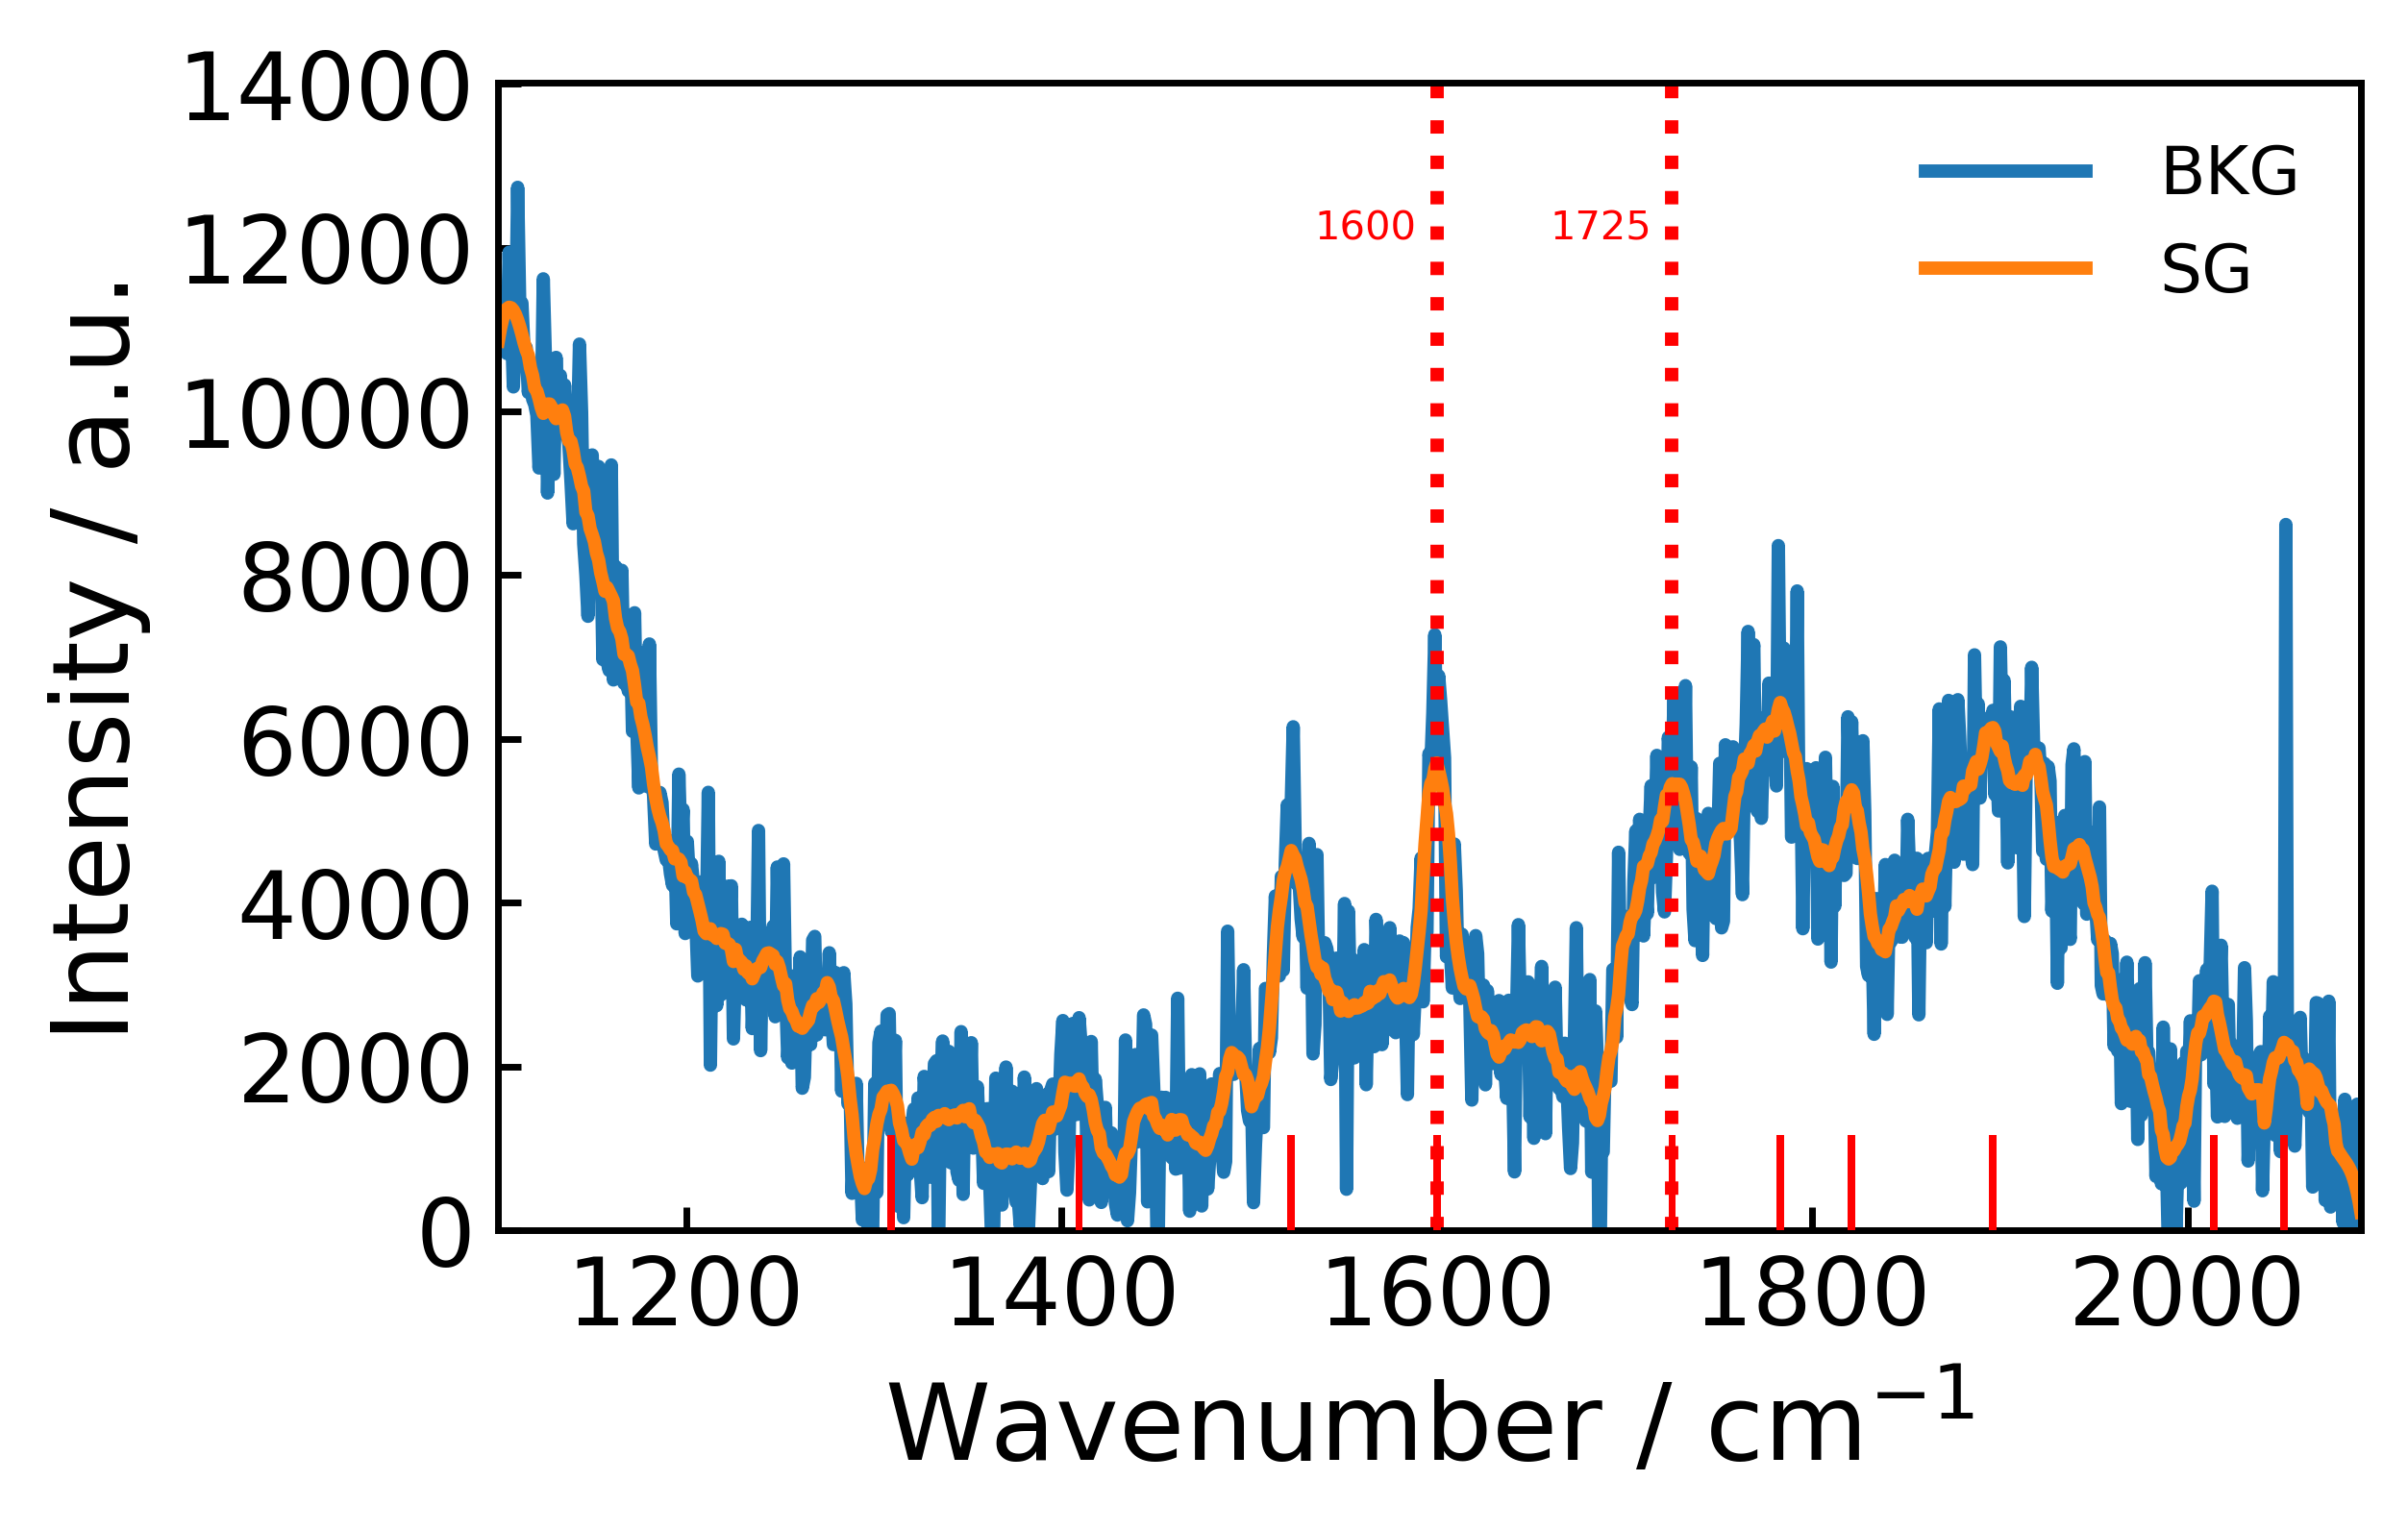

In [3]:
# specify plot parameters
spatial_index=1 # initial spectral plot will take the spectrum at this spatial location
wav_interest=[1600,1725] # specify a list of wavenumbers of interest

# extract spectrum for specified spatial point
print('Will plot at X='+str(index_fitted[spatial_index]))
spectrum=data_fitted2[spatial_index]
spectrum_SG=data_fitted_SG2[spatial_index]

# find peaks in spectrum
peaks, _ = find_peaks(spectrum_SG, prominence=800)
wav_peaks=[]
for peak in peaks:
    wav_peaks.append(wav_points[peak])
print('Peaks in wavenumber:'+str(wav_peaks))

# plot filtered and unfiltered data with peaks found
with rc_context(fname=rc_fname):
    plt.bar(wav_peaks,abs(min(spectrum))*1.1,width=4,color='red',zorder=4)
    plt.plot(wav_points,spectrum,label='BKG')
    plt.plot(wav_points,spectrum_SG,label='SG')
    for wav in wav_interest:
        plt.axvline(wav,ls=':',color='red',lw=2)
        plt.text(wav-65,max(spectrum*0.95),str(wav),fontsize=6,color='red')
    plt.xlim(min(wav_points),max(wav_points))
    plt.ylim(0,max(spectrum*1.1))
    plt.xlabel('Wavenumber / cm$^{-1}$')
    plt.ylabel('Intensity / a.u.')
    plt.legend(fontsize=10)

Closest wavenumber to 1600 is 1599.913086.
Closest wavenumber to 1725 is 1725.300781.


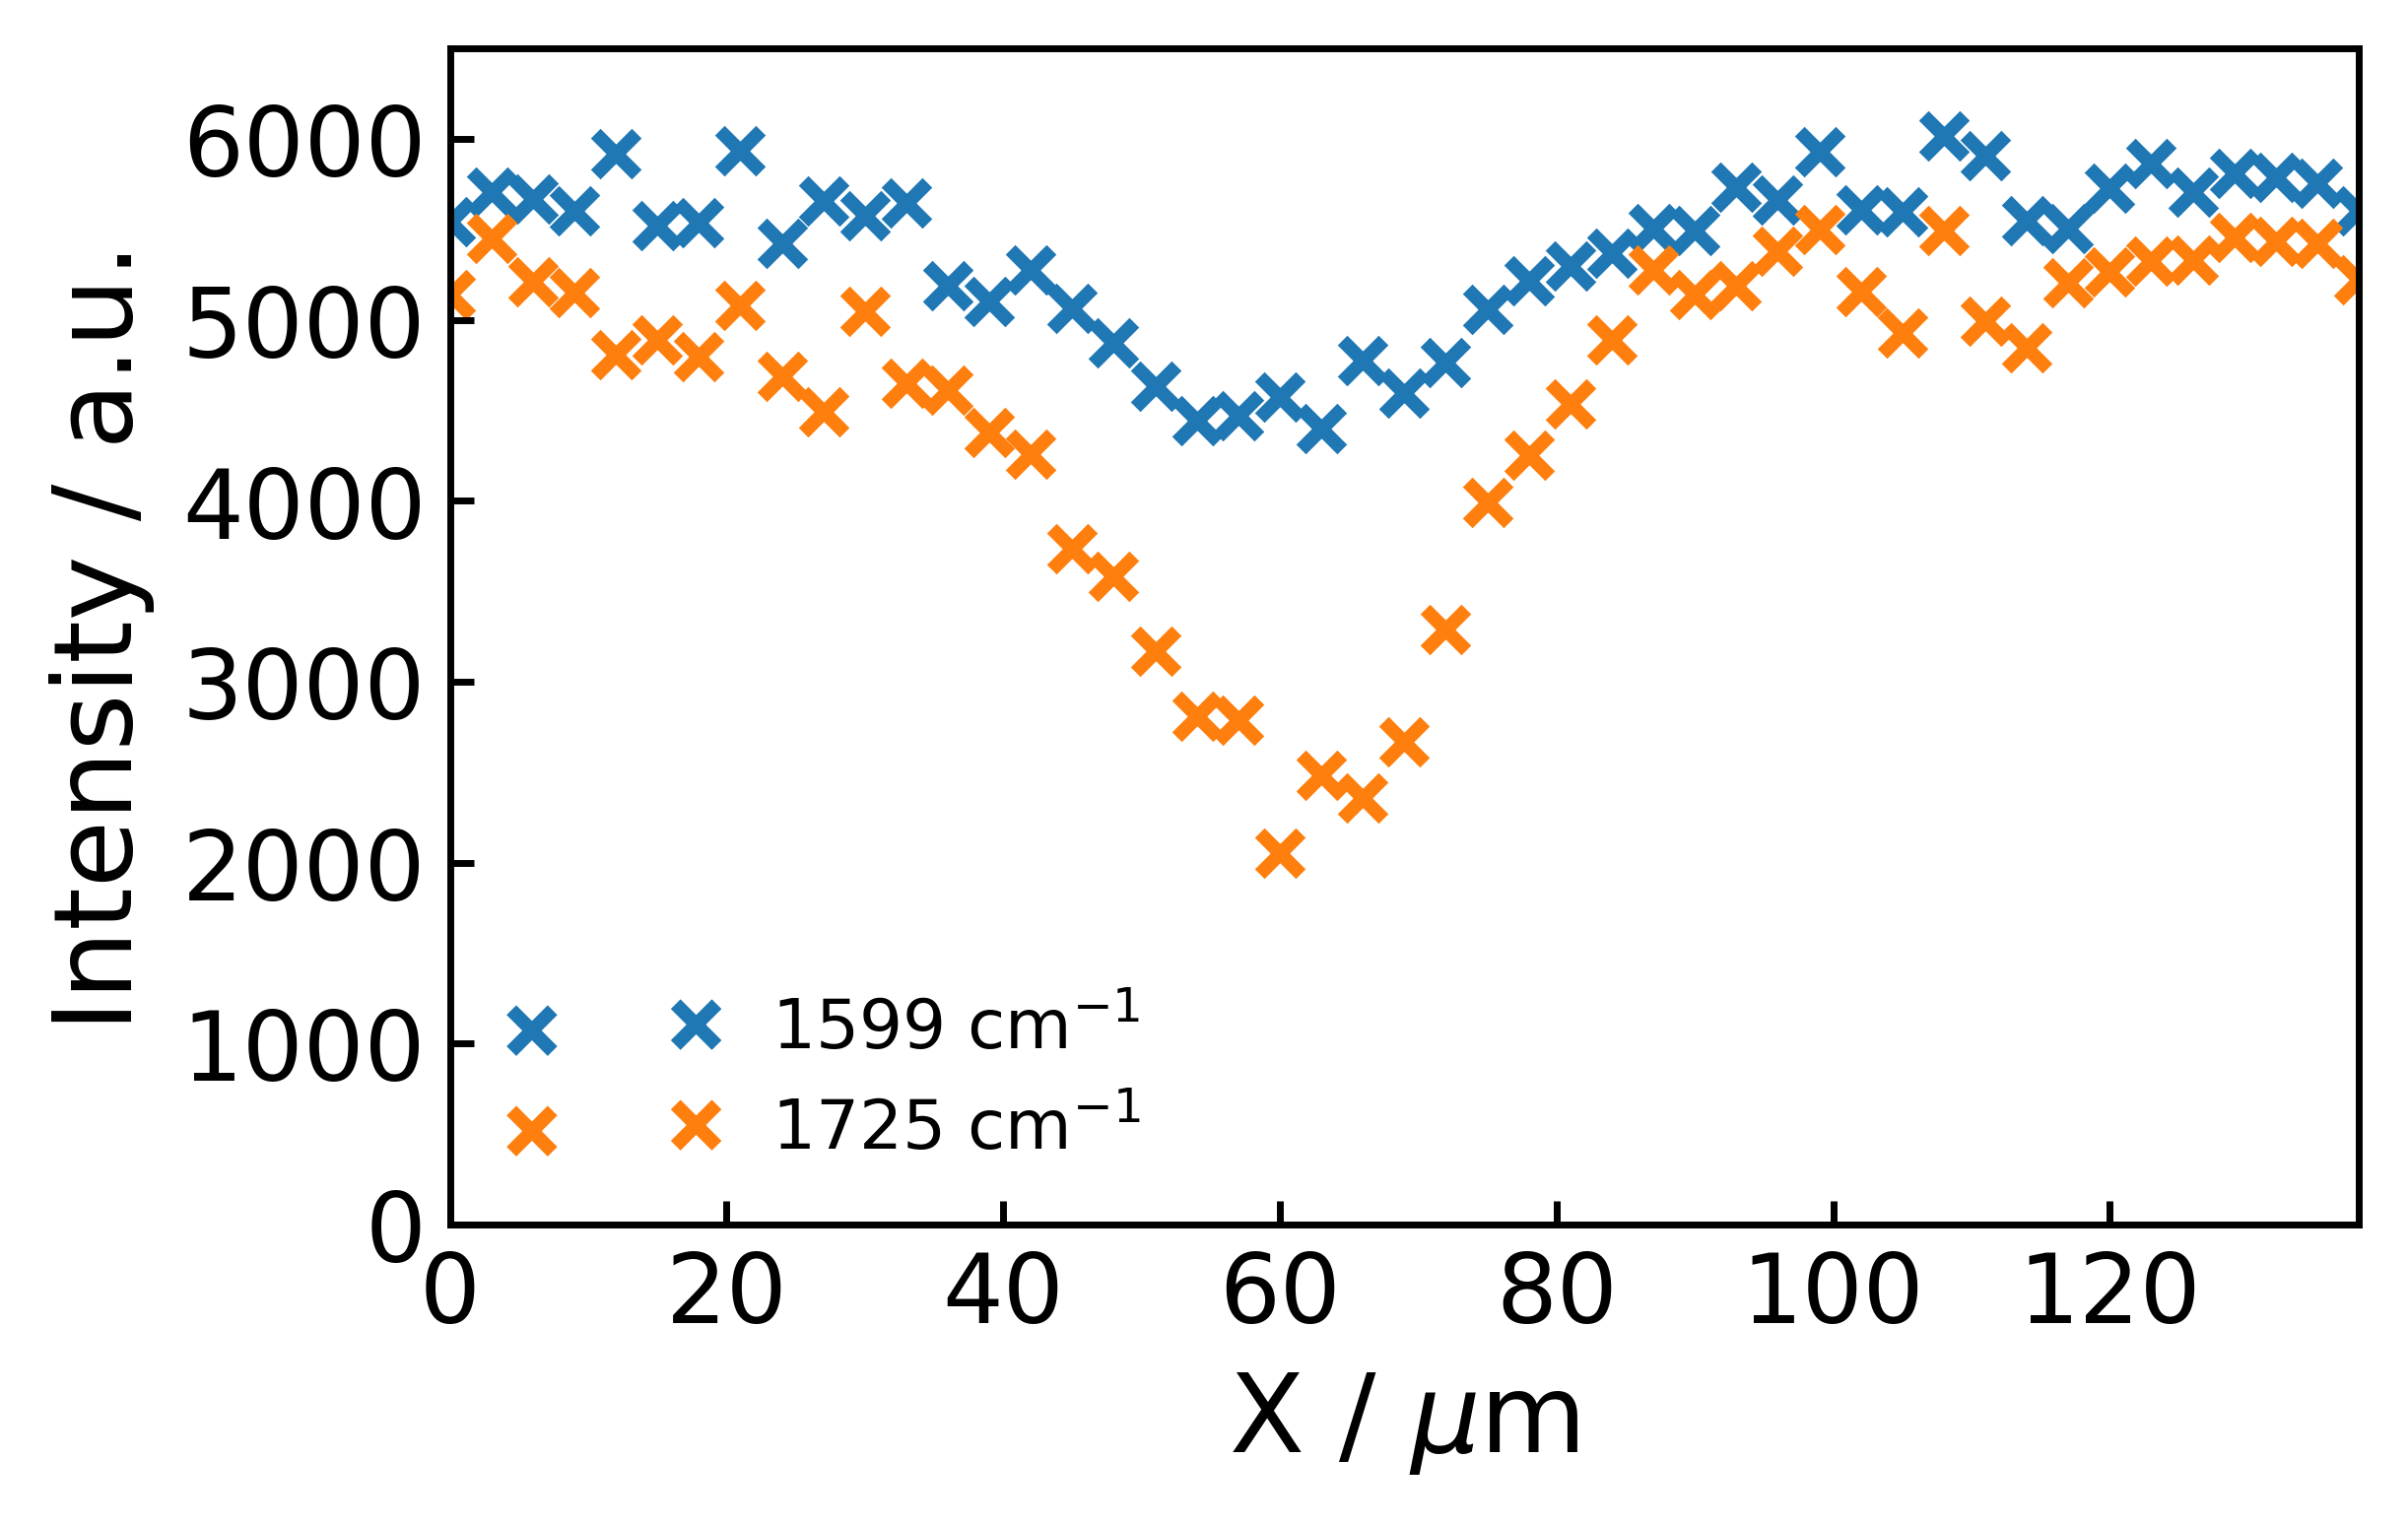

In [4]:
# find closest wavenumbers to specified wavenumbers of interest
wav_index=[]
for counter_w, wav in enumerate(wav_interest):
    wav_index.append(find_nearest_wav(wav_points,wav))
    print('Closest wavenumber to '+str(wav)+' is '+str(wav_index[counter_w])+'.')

# create new DataFrames reduced to the wavenumbers of interest
data_df=pd.DataFrame(data_fitted_SG2,index=index_fitted,columns=wav_points)
data_red={}
for wav in wav_index:
    data_red[wav]=data_df[wav]

# plot Raman counts as a function of position
with rc_context(fname=rc_fname):
    for wav in wav_index:
        plt.scatter(np.subtract(data_red[wav].index,min(x_points)),data_red[wav].values,marker='x',label=str(int(wav))+' cm$^{-1}$')
    plt.xlim(0,max(x_points)-min(x_points))
    plt.ylim(0,6500)
    plt.xlabel('X / $\mu$m')
    plt.ylabel('Intensity / a.u.')
    plt.legend(fontsize=10)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


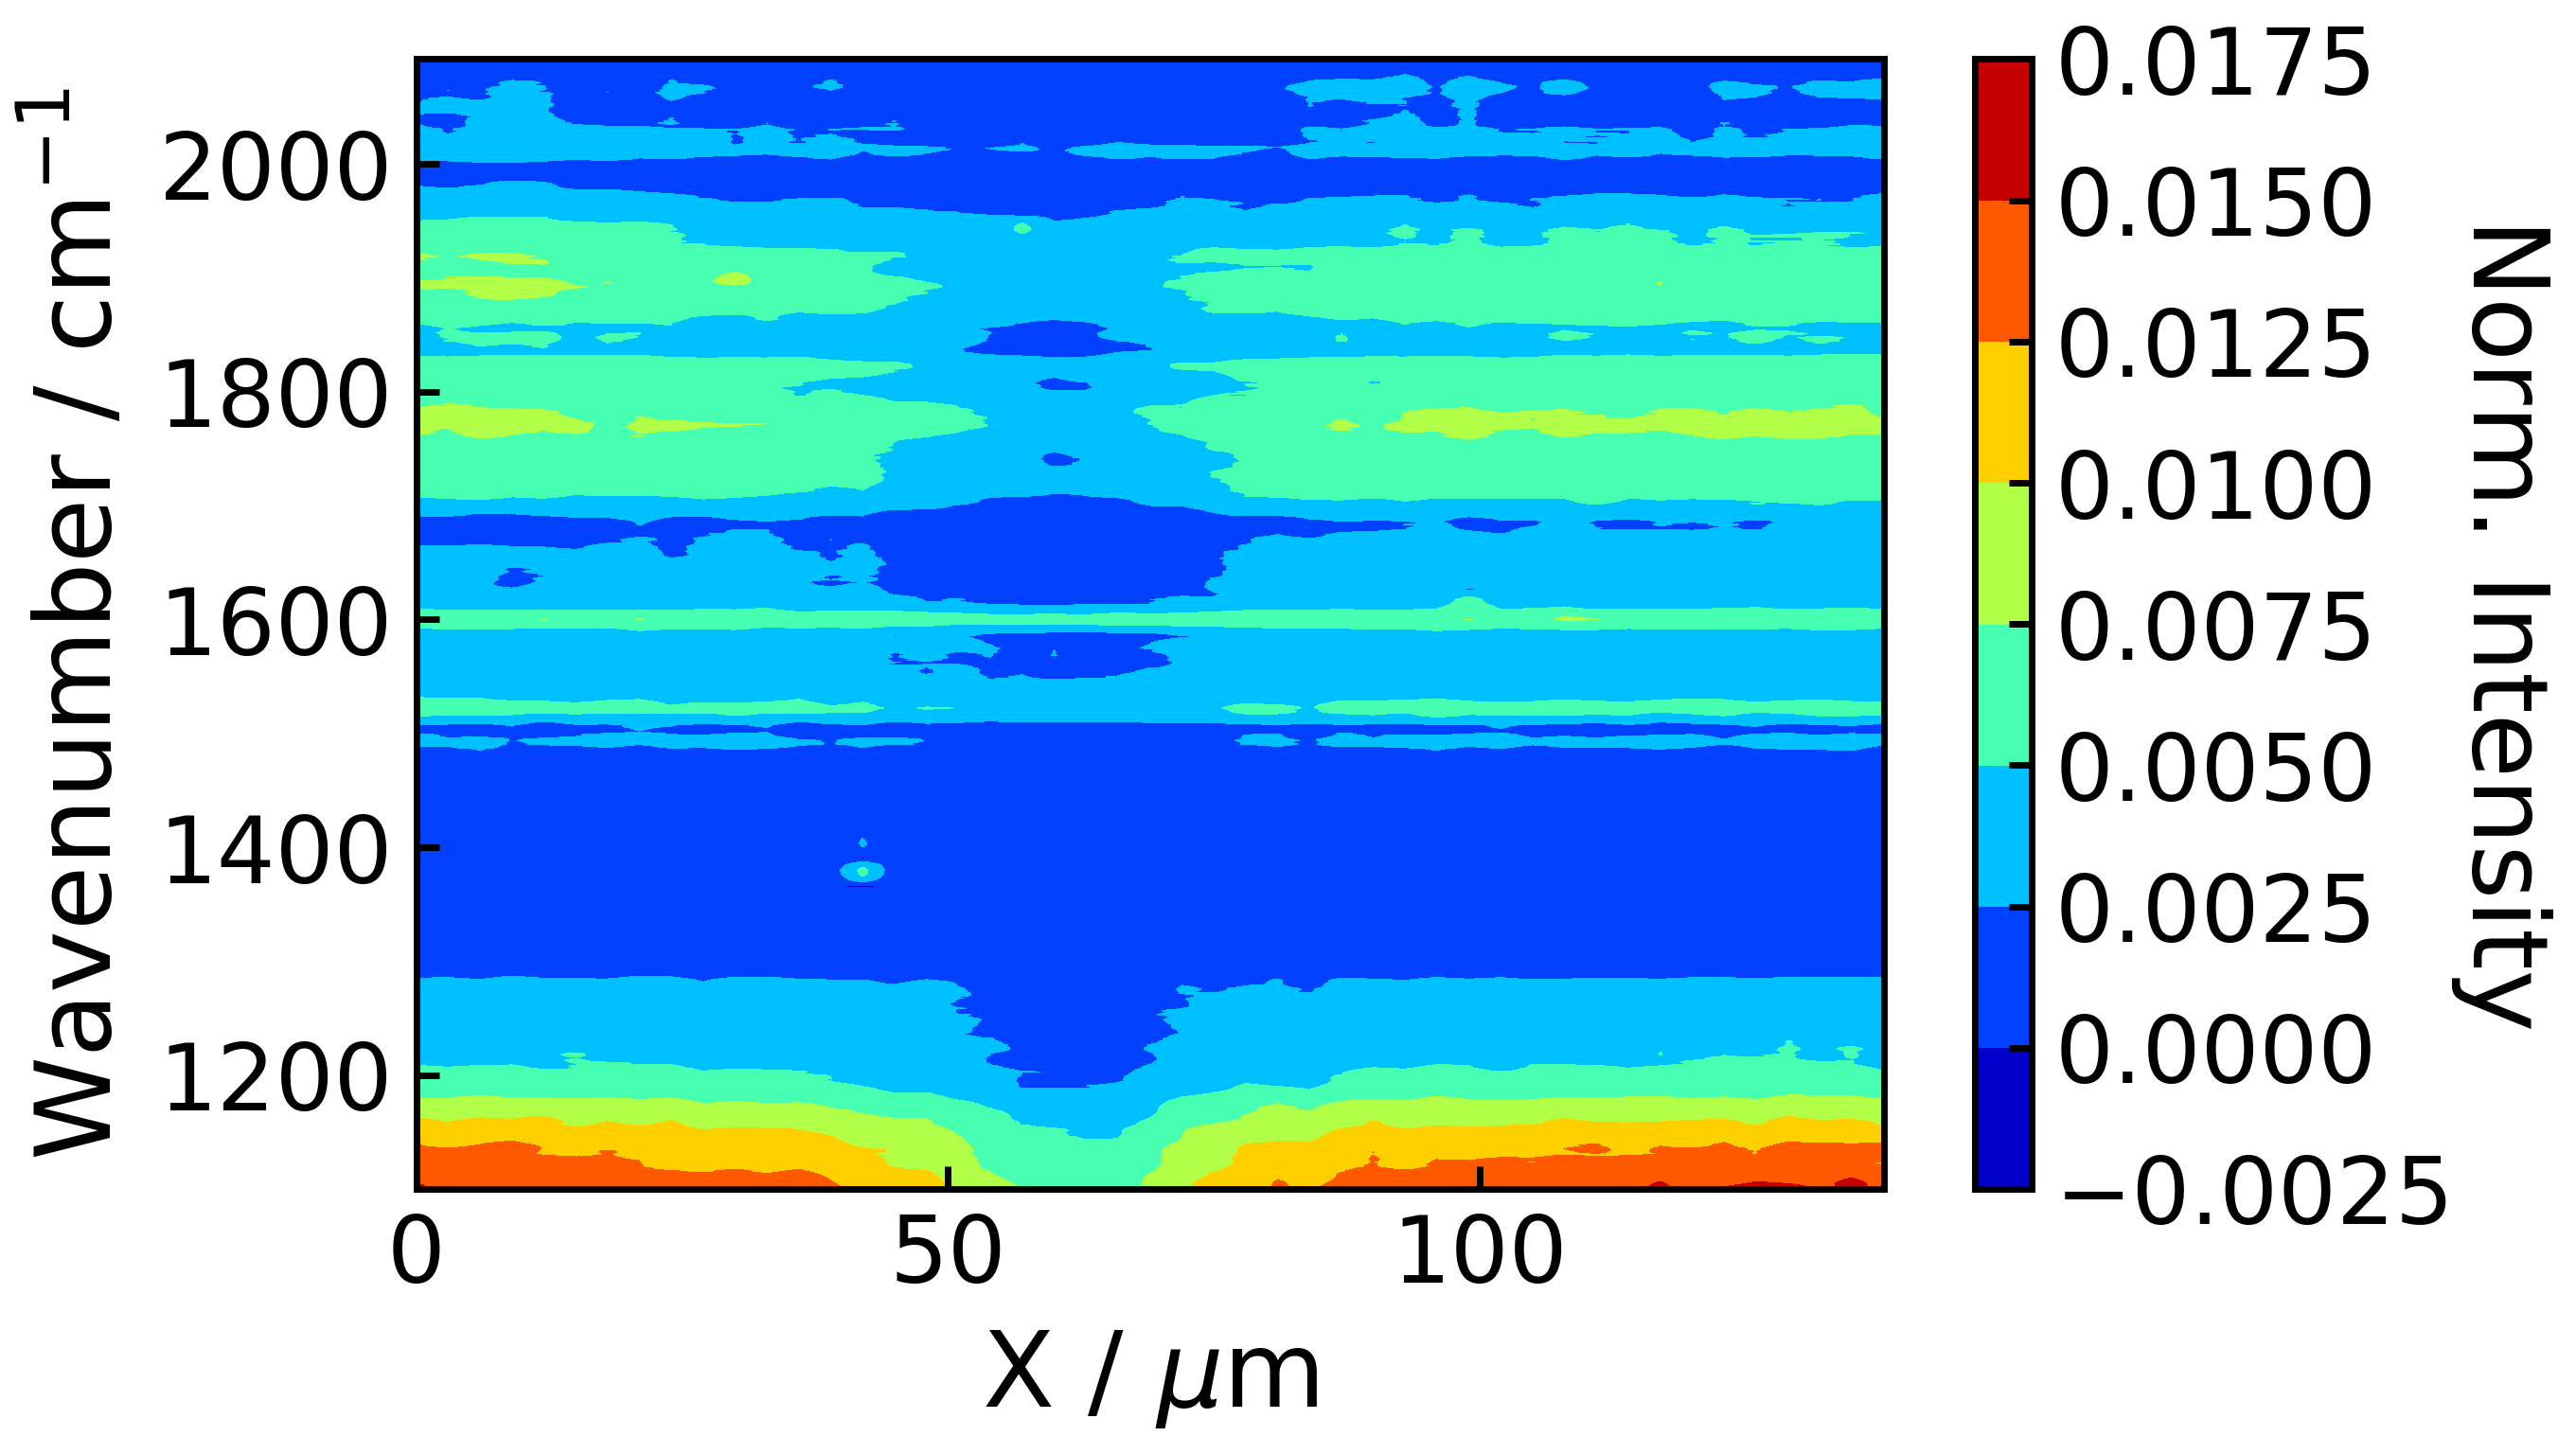

In [5]:
# normalise counts and create 2D colour map
norm_z_arr=normalize_2d(data_df.values)

%matplotlib inline
with rc_context(fname=rc_fname):
    cb=contourf(np.subtract(x_points,min(x_points)), wav_points, np.transpose(norm_z_arr),cmap='jet')
    xlabel("X / $\mu$m")
    ylabel("Wavenumber / cm$^{-1}$")
    cbar=colorbar(cb)
    cbar.set_label('Norm. Intensity', rotation=270,labelpad=15)
    plt.show()

Text(0.5, 0, 'Norm. Int.')

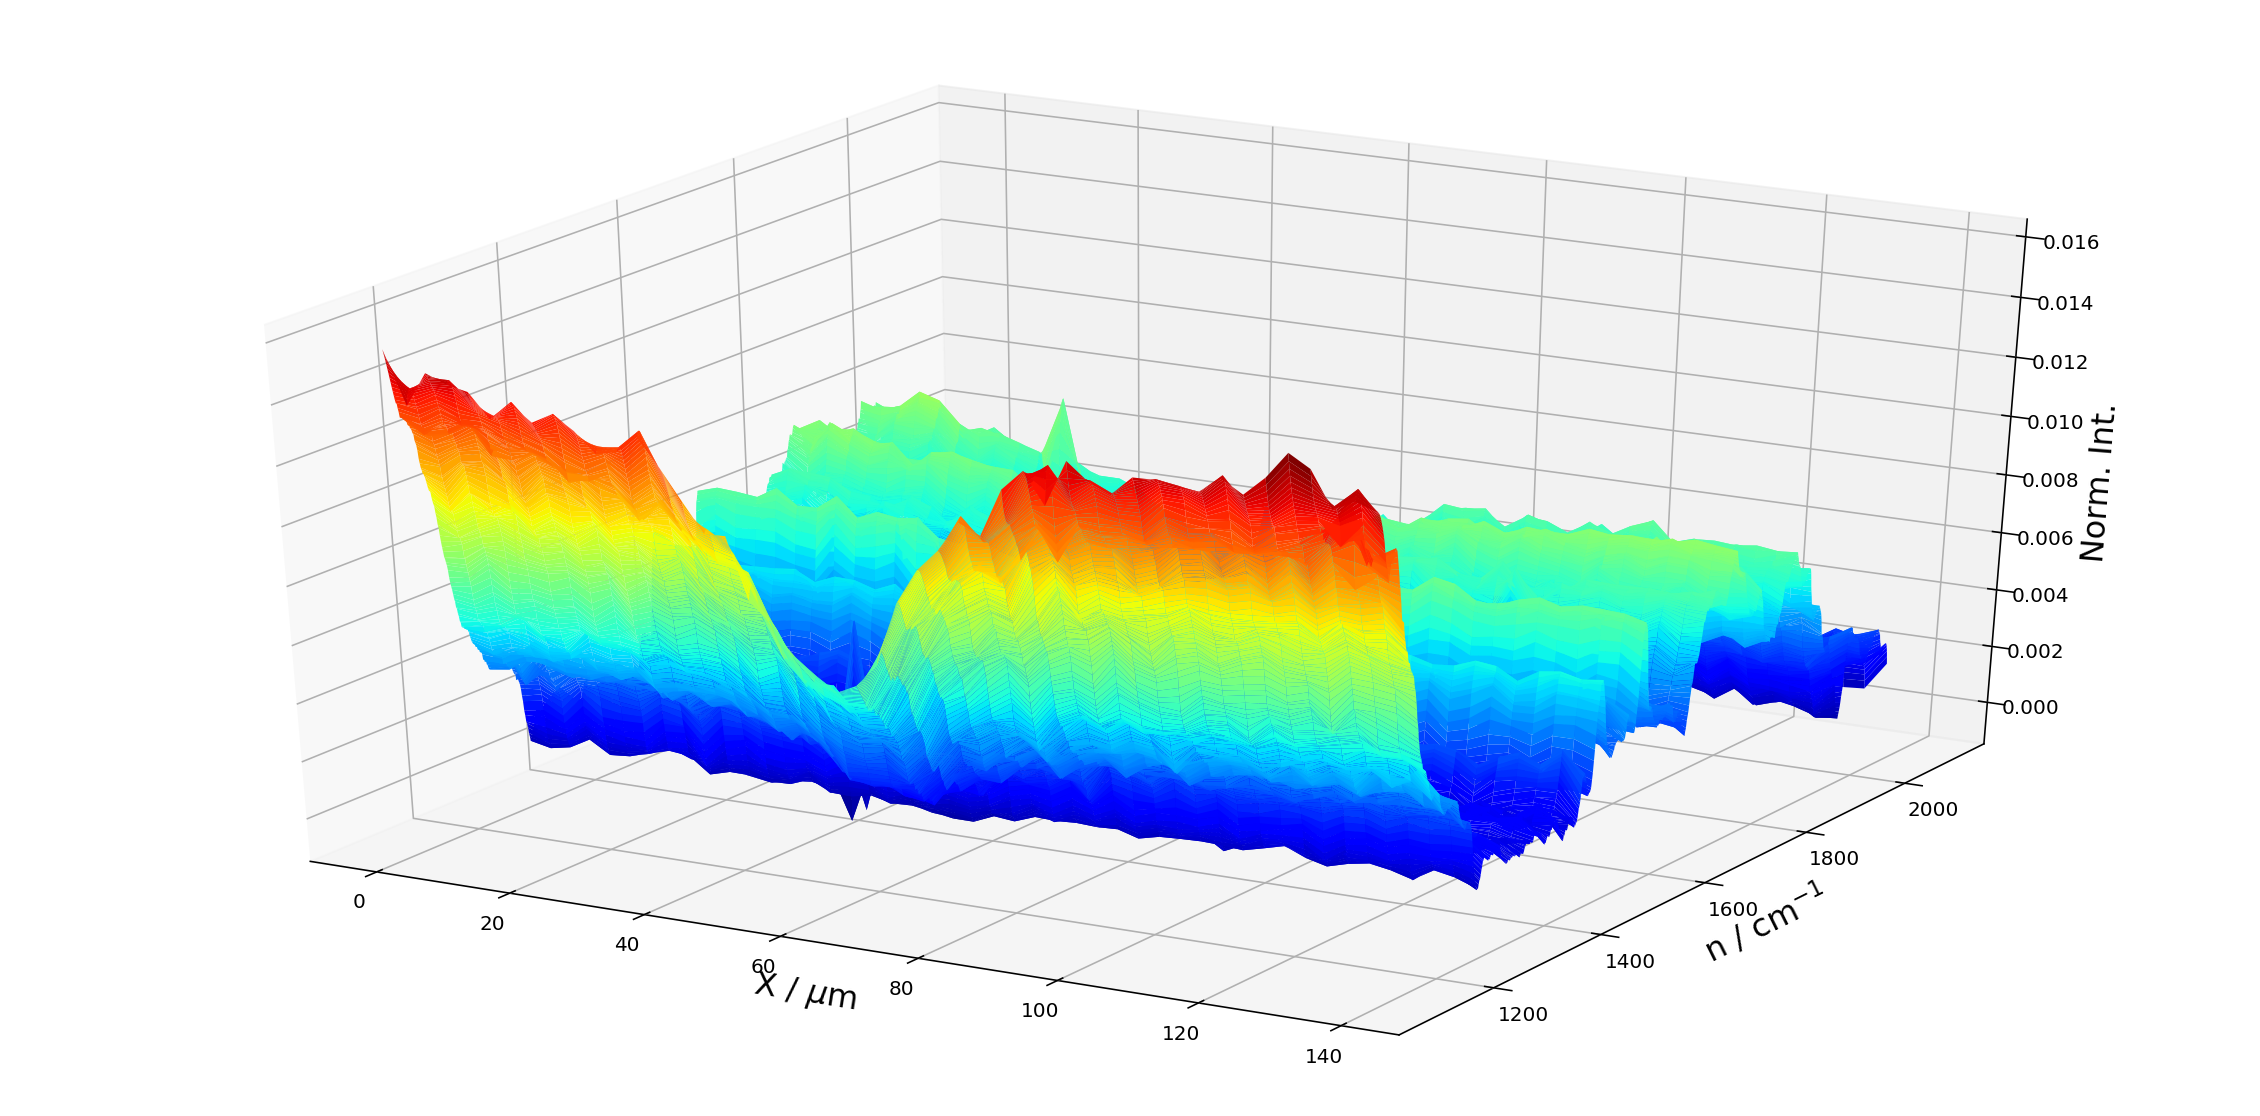

In [6]:
# create 3D plot
X_1, Y_1 = np.meshgrid(np.subtract(x_points,min(x_points)),wav_points)

%matplotlib qt
fig = plt.figure(figsize=(20,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X_1, Y_1, np.transpose(norm_z_arr), rstride=1, cstride=1,cmap='jet', edgecolor='none')
ax.set_xlabel('X / $\mu$m',fontsize=16)
ax.set_ylabel('n / cm$^{-1}$',fontsize=16)
ax.set_zlabel('Norm. Int.',fontsize=16)